# 2. Train autoencoder

## 2.1 Set environment
For building the neural network, Keras is used as an interface to TensorFlow . Tensorflow (https://www.tensorflow.org/) is an open-source library for building neural network developed by Google. Keras (https://keras.io/) is an open-source python library providing a more high level and user-friendly interface to the Tensorflow backend. 
We load the Keras modules and set the location of the data file in the file variable.

In [2]:
import numpy as np
#import keras
from keras import layers
from keras.models import save_model, load_model
from keras.callbacks import TensorBoard
from isoplot import isoplot
# Set location of data file
file="data/era20c.npy"

## 2.2 Create train, validate and test datasets
After randomizing the order of the data, the dataset is split in 3 parts:
- a train dataset for training the NN with 90% of the data
- a validation dataset, used to validate the model during training, with 5% of the data
- a test dataset, which is not used during training, to evaluate the model, with 5% of the data

In [2]:
# N is the size of the test and validation dataset
N = 2000
data = np.load(file)
i = np.argsort(np.random.random(data.shape[0]))
data = data[i]
test = data[:N//2]
validate = data[N//2:N]
train = data[N:]

## 2.3 Architecture of the neural network
We will use a convolute autoencoder neural network to compress our section of the ERA-20C dataset with the MSP and Z500 data. An autoencoder consits of 2 parts: an encoding and a decoding part. Autoencoders are used for dimension reduction, as can also be done with principal component analysis. However the power of of autoencoders lies in the non-linearity. 

<img src="https://upload.wikimedia.org/wikipedia/commons/3/37/Autoencoder_schema.png" width=200 height=200 />

Autoencoder are also for for noise reduction in images. The autoencoder architecture used here is based on an image processing autoencoder. It uses convolute layers which are able to detect spacial relationships within pictures or maps. Alle convolution layers used are based on a 3x3 kernel, and so have 9 parameters to learn. Our input values are maps of 32x64 with 2 channels: MSP and Z500. The first convolutional layers keeps the spacial dimension, but increases the number of channels to 32. So this layer has 2x32 kernels, plus 32 biases, giving in total 608 parameters to learn. Convolutional layer are followed by 2x2 pooling layers, which are taking the maximum of the 4 grid points. Using these the spacial dimension is reduced by a factor 2. We use the convolute/pooling combination 3 times, going from 32x64 to 4x8. We also reduced the number of channels to 1. This give a total dimension reduction factor of 128, from 4096 to 32.

The decoding part is a "mirror" of the encoding part, using nearest neighbour upsampling layers instead of pooling layers. So the spacial dimension is multiplied by 2 for each upsampling layer. The model will be trained so that after compressing and decoding, the output is as close as possible to input. This is done by minimizing the mean square error  (MSE) over all gridpoint and channels between the output and input. The Adam optimizer is used, which is variant of the stochastic gradient descent algorithm. Rectified Linear Unit (ReLu) activation functions are used, except for the one preceding the MSE operator. Tuning has been done on the hyperparameters (type and numbers of layers, dimensions, channels, activation functions,...), but further improvement can probably be done.

In [3]:
# Encoder (32,64,2) - > (4,8,1)
input = keras.Input(shape=(32, 64, 2))
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
encoded = layers.Conv2D(1, (3, 3), activation='relu', padding='same')(x)

# Decoder (4,8,1) -> (32,64,2)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(32, (3, 3), activation='relu',padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
decoded = layers.Conv2D(2, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = keras.Model(input, decoded)
autoencoder.compile(optimizer='adam', loss='MSE')
print(autoencoder.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 64, 2)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 64, 32)        608       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 32, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 32, 16)        4624      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 16, 16)        0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 16, 8)          1160  

2022-06-09 17:46:40.195033: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-06-09 17:46:40.195060: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-06-09 17:46:40.195077: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ai): /proc/driver/nvidia/version does not exist
2022-06-09 17:46:40.195246: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## 2.4 Train the model
Here the model is trained. The epoch number is specifying how many cycles over the complete dataset are done. The batch size specifies after how many samples the parameters are updated by the back propagation algorithm. Dependent on the computer power, this step can take a while. Afterwards the model is saved in a hdf file.

In [4]:
autoencoder.fit(train, train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(validate, validate),
                callbacks=[TensorBoard(log_dir='/tmp/autoencoder')])

autoencoder.save("data/era20c.h5")
#save_model(autoencoder,"model2")
#autoencoder.save_weights("data/weights2.h5")

Epoch 1/50
151/151 [==============================] - 48s 316ms/step - loss: 0.0098 - val_loss: 0.0039
Epoch 2/50
151/151 [==============================] - 50s 332ms/step - loss: 0.0030 - val_loss: 0.0026
Epoch 3/50
151/151 [==============================] - 49s 324ms/step - loss: 0.0022 - val_loss: 0.0018
Epoch 4/50
151/151 [==============================] - 50s 334ms/step - loss: 0.0016 - val_loss: 0.0014
Epoch 5/50
151/151 [==============================] - 49s 323ms/step - loss: 0.0013 - val_loss: 0.0011
Epoch 6/50
151/151 [==============================] - 49s 323ms/step - loss: 0.0011 - val_loss: 0.0010
Epoch 7/50
151/151 [==============================] - 51s 337ms/step - loss: 0.0010 - val_loss: 9.9293e-04
Epoch 8/50
151/151 [==============================] - 49s 325ms/step - loss: 9.8555e-04 - val_loss: 9.4621e-04
Epoch 9/50
151/151 [==============================] - 51s 335ms/step - loss: 9.3448e-04 - val_loss: 9.3659e-04
Epoch 10/50
151/151 [==============================] 

## 2.5 Start tensorboard
The training can be followed up, using the tensorboard.

In [13]:
%%bash
tensorboard --host 0.0.0.0 --logdir=/tmp/autoencoder 2> /dev/null &
#firefox 127.0.0.1:6006 &

Process is interrupted.


## 2.6 Evaluate the model

In [6]:
score = autoencoder.evaluate(test, test, verbose=0)
print('Test loss:', score)

Test loss: 0.000786717573646456


## 2.7 Compare the isoplots 

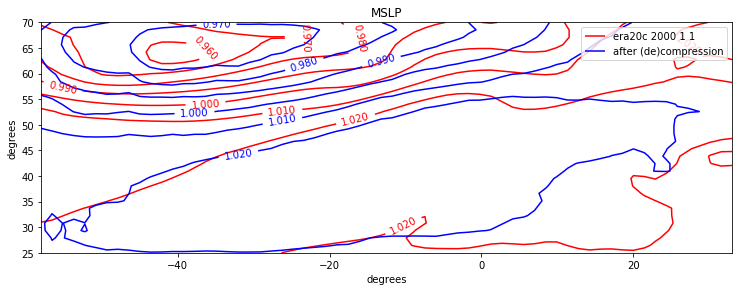

In [11]:
# set date "%Y %-m %-d"
date = "2000 1 1"

# load data
autoencoder = load_model("data/autoencoder.h5")
x = np.load(file)
dates = np.load("data/dates.npy")
zone = np.load("data/zone.npy")
scale = np.load("data/scale.npy")
date_index = np.where(dates == date)
x_in = x[date_index]

# compare output with input
x_out = autoencoder.predict(x_in) 
isoplot(x_in[0,:,:,0],x_out[0,:,:,0],"era20c "+date,"after (de)compression",zone,scale[0])